# Political Tweets Analysis

## Introduction

Can we predict if a political tweet has a Democrat or Republican inclination? Can we know the overall sentiment of the online-speech coming from Democrats and Republicans in digital communities?

Welcome to this Jupyter Notebook dedicated to the analysis of political tweets! In this project, we delve into the fascinating world of political discourse on social media. Our goal is to gain insights into the dynamics of political discussions by analyzing a dataset of tweets.

### Data Overview

The dataset is comprised of political tweets, encompassing a variety of topics and sentiments. Throughout this analysis, we perform Exploratory Data Analysis (EDA) and engage in Feature Engineering to extract valuable information. Notably, a "retweets" column is introduced to binary code tweets that are retweets, and hashtags are systematically extracted and categorized into Democrat and Republican lists. These hashtags are consolidated in a "Hashtags" column, providing a quick reference for each tweet's associated hashtags. Additionally, the "Party" column is binarized to facilitate classification tasks.

### EDA

An extensive Exploratory Data Analysis (EDA) will be conducted to gain valuable insights and enrich the subsequent analytical processes. The initial step involves obtaining a general overview of the dataset, including the assessment of the number of records, features, and their respective data types, ensuring data integrity. Attention will be given to handling missing values.

EDA will also involve creating visualizations, such as line plots or bar charts, to highlight trends or patterns specific to each political party, facilitating a nuanced understanding of communication strategies. Feature engineering may be employed to enhance the predictive power of the model, including the creation of numerical representations for text data using techniques like TF-IDF or word embeddings. 

To better understand the landscape of political tweets, I present visualizations such as the top hashtags associated with each party and word clouds highlighting the most prevalent hashtags. These visualizations serve as powerful tools for grasping the key themes within the dataset.

### Data Cleaning

To ensure the quality of our analysis, a comprehensive data cleaning process is implemented. This involves tokenizing tweets to lowercase, removing hashtags, links, punctuations, and handles. This step is crucial for preparing the data for sentiment analysis.


In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
# Load DataFrame into variable df
df = pd.read_csv('RepublicanVsDemocrat.csv')
df.head()

# Check the amount of tweets
print(len(df))

9703


In [3]:
# Check for null values in the dataset
df.isna().sum()

user_id    0
tweet      0
dtype: int64

Now we will read the PoliticalUsernamesAndIds.csv file to map the user_id with our df dataframe and read the party affiliation for each user

In [4]:
# Read PoliticalUsernamesAndIds.csv into a dataframe
politicalhandles = pd.read_csv('PoliticalUsernamesAndIds.csv')

# Display results
politicalhandles.head()

,id,name,username,party
0,2916086925,Rep. Alma Adams,RepAdams,D
1,76452765,Robert Aderholt,Robert_Aderholt,R
2,3018670151,Rep. Pete Aguilar,RepPeteAguilar,D
3,1612483604071727104,Mark Alford,RepMarkAlford,R
4,2964287128,Rick W. Allen,RepRickAllen,R


In [5]:
# Create Party column on df
df['party'] = None

# display results
df.head()

,user_id,tweet,party
0,76452765,"On Joe Biden's first day in the Oval Office, h...",None
1,76452765,I was sorry to hear of the passing of longtime...,None
2,76452765,RT @1819News: U.S. Rep. Robert Aderholt (R-Hal...,None
3,76452765,I’m sorry to hear of Anthony’s passing. He fre...,None
4,76452765,H.R. 6914 Pregnant Students’ Rights Act: Colle...,None


In [6]:
# Iterate through each row in df to map it with user_id and obtain the party affiliation
for i in range(len(df)):
    user_id = df.loc[i, 'user_id']
    matching_row = politicalhandles[politicalhandles['id'] == user_id]
    
    if not matching_row.empty:
        df.loc[i, 'party'] = matching_row['party'].iloc[0]
    else:
        # Handle the case where there is no matching row in members_data2
        df.loc[i, 'party'] = None  # or any other value indicating no match

In [7]:
# Check results
df.head()

,user_id,tweet,party
0,76452765,"On Joe Biden's first day in the Oval Office, h...",R
1,76452765,I was sorry to hear of the passing of longtime...,R
2,76452765,RT @1819News: U.S. Rep. Robert Aderholt (R-Hal...,R
3,76452765,I’m sorry to hear of Anthony’s passing. He fre...,R
4,76452765,H.R. 6914 Pregnant Students’ Rights Act: Colle...,R


In [8]:
# Convert object type column to string
df['party'] = df['party'].astype(str)

In [9]:
# Check if the dataset is balanced, and not skewed, between democrat and republican tweets. 
df['party'].value_counts()

party
D      4785
R      4760
nan     158
Name: count, dtype: int64

We see that there are some null 'part' values. This should not be like thise. Either the errors was dragged from the Twitter_hacking.ipynb notebook or these persons don't have a party affiliation.

Will have to take a look at this to address this error

In [10]:
# Check where the 'party' columns has null values
filtered_df = df[(df['party'] != 'R') & (df['party'] != 'D')]

# Check the name of the user_id's with null party values to perform a manual inspection
filtered_df['user_id'].value_counts()

user_id
1583530102297600000    23
226639880              23
1143841                23
1612865196489412608    23
1206227149             23
1382395679700439041    22
1563316176717246464    21
Name: count, dtype: int64

In [11]:
# Check the username of each of these user_id's
politicalhandles[politicalhandles['id']==226639880 ]

,id,name,username,party
153,226639880,Guillaume,tx,NaN


Through a manual inspection of the original dataset containing senators' usernames, I will validate and confirm the necessary actions for each handle. For handles that genuinely represent a party affiliation, corrections will be made in the dataset to ensure accuracy. On the other hand, handles like "tx" and "ct" that appear to be tweets erroneously scrapped will be identified and subsequently deleted from the dataset. This meticulous review and corrective process aim to enhance the dataset's reliability and eliminate inaccuracies stemming from misinterpreted or irrelevant handles.


226639880              23 : tx -> drop

1143841                23 : ct -> drop

1583530102297600000    23 : RepLCD -> republican

1612865196489412608    23 : RepValHoyle -> democrat

1206227149             23 : RepMarkPocan -> democrat

1382395679700439041    22 : RepJuliaLetlow -> republican

1563316176717246464    21 : RepFinstad -> republican

In [12]:
# drop rows of tweets from erroneously scraped accounts
df.drop(df[df['user_id'].isin([226639880, 1143841])].index, inplace=True)

# Check results
df[df['user_id']==226639880]

,user_id,tweet,party


Rows have been successfully deleted!

Now we will fix the party value for the other rows`

In [13]:
# Dictionary to map user_id values to corresponding party values
user_id_to_party_mapping = {
    1583530102297600000: 'R',
    1612865196489412608: 'D',
    1206227149: 'D',
    1382395679700439041: 'R',
    1563316176717246464: 'R'
}

# Iterate through the DataFrame and update 'party' column
for index, row in df.iterrows():
    user_id = row['user_id']
    if user_id in user_id_to_party_mapping:
        df.at[index, 'party'] = user_id_to_party_mapping[user_id]

In [14]:
df['party'].value_counts()

party
D    4831
R    4826
Name: count, dtype: int64

We have successfully fixed the null values in the party columns. 

We can see that the tweet distribution is very balanced between both parties which makes a good dataset to work with since it will not be biased towards any party

## 1.  EDA

### Checking for Nulls and Duplicates

In [15]:
# Check of unique values
for col in df.columns:
    selected =  df[col]
    n_unique = selected.unique().shape[0]
    print("The column {} has {} unique values".format(col,n_unique,len(df)))

The column user_id has 424 unique values
The column tweet has 9523 unique values
The column party has 2 unique values


This tells us the dataset is compiled of tweets from 426 users and there are 9569 unique tweets out of 9703.

Now we will check for duplicate values

In [16]:
duplicates = df[df['tweet'].duplicated() == True]
duplicates.shape

(134, 3)

There are 134 duplicate values

We are going to show the Tweets that are duplicate and delete them.

In [17]:
duplicates

,user_id,tweet,party
637,1176522535531360257,RT @Weaponization: 🚨 #BREAKING: Federal Govern...,R
1142,816157667882373120,"RT @BipartisanVets: .@RepCarbajal, @RepDonBaco...",D
1346,1499512178013057032,"RT @USProgressives: 51 years ago, Roe v Wade w...",D
1756,1274852794206388225,RT @GOPoversight: 🚨 TRANSCRIPT RELEASE 🚨\n\nTo...,R
1757,1274852794206388225,RT @GOPoversight: 🚨 TRANSCRIPT RELEASE 🚨\n\nTo...,R
...,...,...,...
9385,281540744,RT @SpeakerJohnson: Our prayers and deepest co...,R
9439,2852998461,"RT @NatResources: Today, the committee unanimo...",R
9447,2852998461,"RT @HouseGOP: Today, we honor the legacy of Ma...",R
9530,1602757312539680770,"RT @SaveLocalBiz: .@RepDesposito, @RepMikeLawl...",R


In [18]:
# We'll drop duplicate tweets from the same handle
df_cleaned = df.drop_duplicates(['user_id', 'tweet'])
df_cleaned.shape
print(f"We have deleted {df.shape[0]-df_cleaned.shape[0]} duplicate tweets from the same Handle")

We have deleted 1 duplicate tweets from the same Handle


In [19]:
# Now we'll drop duplicate tweets from the same part
df_cleaned2 = df_cleaned.drop_duplicates(['party', 'tweet'])
df_cleaned2.shape
print(f"We have deleted {df_cleaned.shape[0]-df_cleaned2.shape[0]} duplicate tweets from the same Party")

We have deleted 128 duplicate tweets from the same Party


So we have deleted 129 out of 135 duplicates. This means there must be 5 duplicates Tweets but from different parties. We will check them for sanity check and leave them since they are representations of both parties It would be biased to leave the tweet content to represent exclusively one party and not the other.

In [20]:
# Check the 5 duplicate tweets.
# This shows the second occurance of the duplicate.
new_duplicates = df_cleaned2[df_cleaned2['tweet'].duplicated() == True]
new_duplicates

,user_id,tweet,party
1142,816157667882373120,"RT @BipartisanVets: .@RepCarbajal, @RepDonBaco...",D
1915,1608891205902794753,RT @freedomcaucus: Americans come to Washingto...,D
2477,1366523868253458437,RT @BipartisanVets: Our members prioritize the...,R
3146,88806753,RT @HIDAorg: HIDA applauds @RepEzell(R-MS) and...,D
3377,1343627416120532992,RT @HouseForeignGOP: Starting today🚨 CHM @RepM...,R


In [21]:
df_cleaned2.shape[0]

9528

From the initial set of 9,703 tweets, we have successfully removed redundancies. Specifically, one duplicated tweet originating from the same handle and 128 duplicates emerging from distinct handles but associated with the same party have been eliminated. This step was taken as these duplicates, originating from the same party, presented identical representations and were thus considered redundant. It's noteworthy that duplicates arising from distinct parties were retained as they contribute to the representation of diverse clusters within the dataset.

Following this cleaning process, our dataset now comprises 9,574 unique tweets, reflecting a refined and more accurate representation for subsequent analyses.

There are 2,908 instances of duplicate tweets with distinct handles. Our objective is to tally the number of unique handles associated with each duplicate tweet. The count of unique handles per duplicate tweet should align with the total count of 2,908, affirming that our dataframe exclusively comprises duplicate values with unique handles.

In [22]:
# The duplicates() == True gives me only the second copy of the tweet
# Let's check if the duplicate indeed is from a different Party
duplicate_check = []

for index, tweet in new_duplicates.iterrows():
    string = tweet['tweet']
    duplicate_check.append(df_cleaned2[df_cleaned2['tweet'].str.startswith(string)])
    
# Concatenate the DataFrames in duplicate_check
duplicate_check_df = pd.concat(duplicate_check, ignore_index=True)

# Display the resulting DataFrame
print(duplicate_check_df)

               user_id                                              tweet  \
0   818975124460335106  RT @BipartisanVets: .@RepCarbajal, @RepDonBaco...   
1   816157667882373120  RT @BipartisanVets: .@RepCarbajal, @RepDonBaco...   
2  1357017361568694274  RT @freedomcaucus: Americans come to Washingto...   
3  1608891205902794753  RT @freedomcaucus: Americans come to Washingto...   
4  1608934316779921408  RT @BipartisanVets: Our members prioritize the...   
5  1366523868253458437  RT @BipartisanVets: Our members prioritize the...   
6  1602788004749344768  RT @HIDAorg: HIDA applauds @RepEzell(R-MS) and...   
7             88806753  RT @HIDAorg: HIDA applauds @RepEzell(R-MS) and...   
8            210926192  RT @HouseForeignGOP: Starting today🚨 CHM @RepM...   
9  1343627416120532992  RT @HouseForeignGOP: Starting today🚨 CHM @RepM...   

  party  
0     R  
1     D  
2     R  
3     D  
4     D  
5     R  
6     R  
7     D  
8     D  
9     R  


We can see that the duplicates are indeed form different parties, we can be sure our dataset is cleaned as desired. We leave these duplicates since it would be biased to leave one tweet accounting for one party but not for the other. This would result in a biased model when predicting future tweets as either democrat or republican.

In [23]:
# For simplicity we will rename our latest dataframe as df_cleaned

df_cleaned = df_cleaned2

### Check for Retweets
Binary column 'Retweets' will be created with the value of 1 of the Tweet is a retweet.

In [24]:
# Take a look at the amount of retweets in our data set
df_cleaned[df_cleaned['tweet'].str.contains('RT')].shape[0]

1517

In [25]:
# Percantage of retweets from the whole data set
pct_of_rt = df_cleaned[df_cleaned['tweet'].str.contains('RT')].shape[0]/df.shape[0]*100
print(f" The percentage of retweets in the dataset is {pct_of_rt}%")

 The percentage of retweets in the dataset is 15.708812260536398%


Now we know that roughly 15.70% of the tweets in the dataset are retweets. That is a considerable amount.

We will create a new binary column in the dataset with value of 1 if its a retweet and 0 if it's not.

In [26]:
# Create new blank columns to determine if tweet is retweeted or not
df_cleaned['is_retweet'] = None

#Check results
df_cleaned['is_retweet']

0       None
1       None
2       None
3       None
4       None
        ... 
9698    None
9699    None
9700    None
9701    None
9702    None
Name: is_retweet, Length: 9528, dtype: object

In [27]:
# Fill columns with binary values based on if tweet is retweet or not

df_cleaned['is_retweet'] = df_cleaned['tweet'].apply(lambda x: 1 if 'RT' in x else 0)

#Check to see if the amount of rows where there is a retweet matches with 19,194 the amount of RT previously calcualted
df_cleaned[df_cleaned['is_retweet']==1].shape

(1517, 4)

C:\Users\erick\AppData\Local\Temp\ipykernel_15352\1415451929.py:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend.legendHandles[0].set_color(colors[0])
C:\Users\erick\AppData\Local\Temp\ipykernel_15352\1415451929.py:19: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend.legendHandles[1].set_color(colors[1])


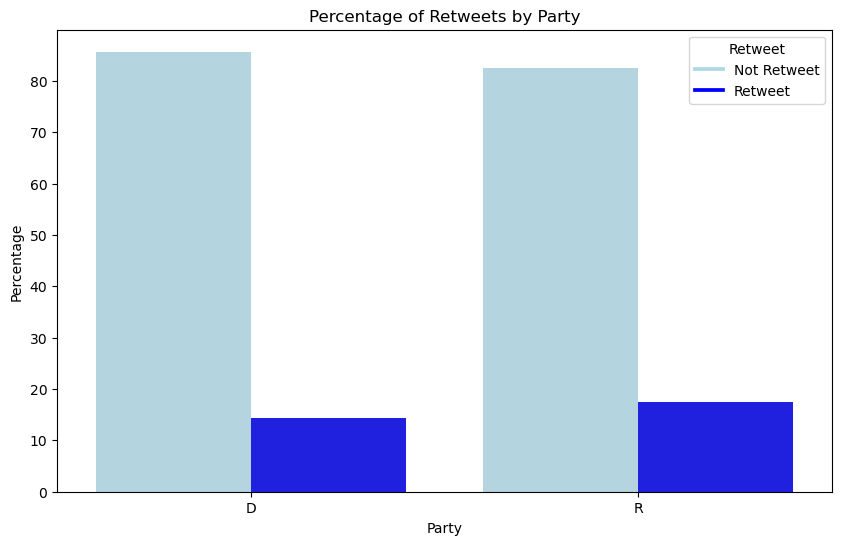

In [28]:
# Calculate the percentage of retweets for each party
retweet_percentage = df_cleaned.groupby('party')['is_retweet'].value_counts(normalize=True) * 100
retweet_percentage = retweet_percentage.rename('Percentage').reset_index()

# Set custom colors for the plot
colors = ['lightblue', 'blue']

# Plot the results
plt.figure(figsize=(10, 6))
sns.barplot(x=retweet_percentage['party'], y=retweet_percentage['Percentage'], hue=retweet_percentage['is_retweet'], palette=colors)
plt.title('Percentage of Retweets by Party')
plt.xlabel('Party')
plt.ylabel('Percentage')

# Customize legend
legend_labels = ['Not Retweet', 'Retweet']
legend = plt.legend(title='Retweet', loc='upper right', labels=legend_labels)
legend.legendHandles[0].set_color(colors[0])
legend.legendHandles[1].set_color(colors[1])

### Binarize Party

- **Democrat = 1**
- **Republican = 0**

In [29]:
# Binarize the Party Column
df_cleaned['is_democrat'] = df_cleaned['party'].apply(lambda x: 1 if 'D' in x else 0)
print(df_cleaned.shape[0])
df_cleaned.head()

9528


,user_id,tweet,party,is_retweet,is_democrat
0,76452765,"On Joe Biden's first day in the Oval Office, h...",R,0,0
1,76452765,I was sorry to hear of the passing of longtime...,R,0,0
2,76452765,RT @1819News: U.S. Rep. Robert Aderholt (R-Hal...,R,1,0
3,76452765,I’m sorry to hear of Anthony’s passing. He fre...,R,0,0
4,76452765,H.R. 6914 Pregnant Students’ Rights Act: Colle...,R,0,0


Now we will extract all of the hashtags in the database

### Extract hashtags for each tweet

We will create a new column holding the hashtags, if any, for each tweet.

Additionally, we will create a list of all hashtags for democrats and republicans.

In [30]:
# Create a new column with the hashtags for each tweet
df_cleaned['hashtags'] = None

#Iterate over each row in df['Tweets']
for index, row in df_cleaned.iterrows():
    # Use regex findall to search for all hashtags in each row
    hashtags = re.findall(r'#(\w+)', row['tweet'])
    if hashtags:
        # Add the hashtags, if any, in the columns 'Hashtags' for each row
        df_cleaned.at[index, 'hashtags'] = hashtags


In [31]:
# Check results
df_cleaned['hashtags']

0                                  None
1                                  None
2                                  None
3                                  None
4                                  None
                     ...               
9698                               None
9699    [LawEnforcementAppreciationDay]
9700                               None
9701                               None
9702                               None
Name: hashtags, Length: 9528, dtype: object

In [32]:
# Create two empty lists to store hashtags
republican_hashtags = []
democrat_hashtags = []

# Loop through each row to add hashtags to list
for index, row in df_cleaned.iterrows():
    if row['is_democrat'] == 1 and row['hashtags'] is not None:
        democrat_hashtags.extend(row['hashtags'])
    elif row['hashtags'] is not None:
        republican_hashtags.extend(row['hashtags'])

##### Visualize the top 10 hashtags for Democrats and Republicans

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'MLKDay'),
  Text(1, 0, 'NationalSchoolChoiceWeek'),
  Text(2, 0, 'FL02'),
  Text(3, 0, 'Bidenomics'),
  Text(4, 0, 'ProLife'),
  Text(5, 0, 'WhyWeMarch'),
  Text(6, 0, 'NationalMilkDay'),
  Text(7, 0, 'SchoolChoiceWeek'),
  Text(8, 0, 'MarchForLife'),
  Text(9, 0, 'IA04')])

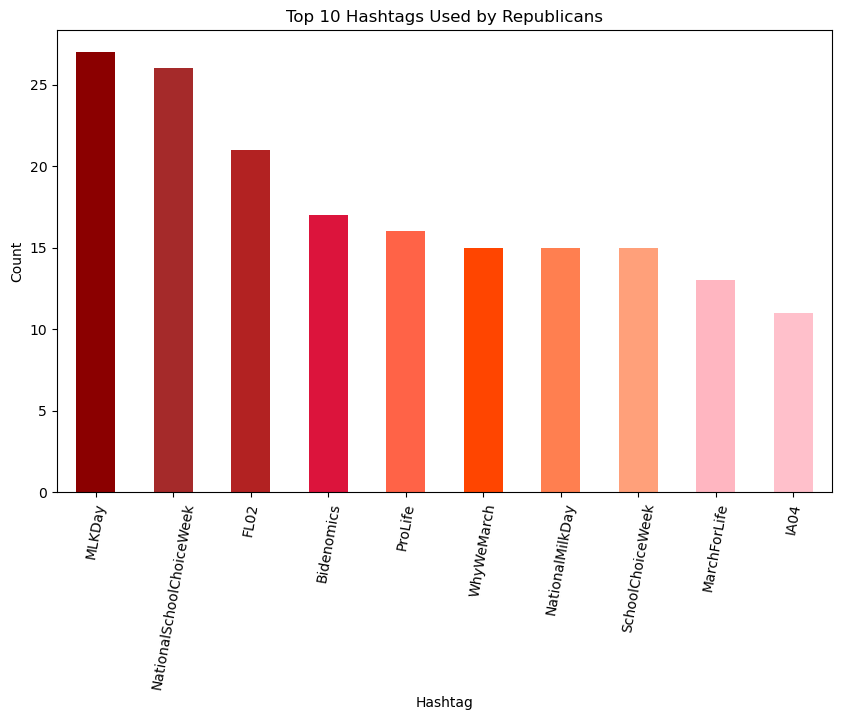

In [33]:
# Plot the 10 most used hasthags for Republicans

# Convert the list of Republican hashtags to a Pandas Series and count occurrences
republican_10 = pd.Series(republican_hashtags).value_counts().head(10)
custom_red_colors = [
    '#8B0000',  # Dark red
    '#A52A2A',  # Brown
    '#B22222',  # Firebrick
    '#DC143C',  # Crimson
    '#FF6347',  # Tomato
    '#FF4500',  # Orange red
    '#FF7F50',  # Coral
    '#FFA07A',  # Light salmon
    '#FFB6C1',  # Light pink
    '#FFC0CB'   # Pink
]

# plot
republican_10.plot(kind='bar', figsize=(10,6), color=custom_red_colors)
plt.title('Top 10 Hashtags Used by Republicans')
plt.xlabel('Hashtag')
plt.ylabel('Count')
plt.xticks(rotation = 80)


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'WIC'),
  Text(1, 0, 'FundWIC'),
  Text(2, 0, 'RoevWade'),
  Text(3, 0, 'MLKDay'),
  Text(4, 0, 'GVSurvivorsWeek'),
  Text(5, 0, 'RoeVWade'),
  Text(6, 0, 'ReproductiveFreedom'),
  Text(7, 0, 'IL03'),
  Text(8, 0, 'PeopleOverPolitics'),
  Text(9, 0, 'ACA')])

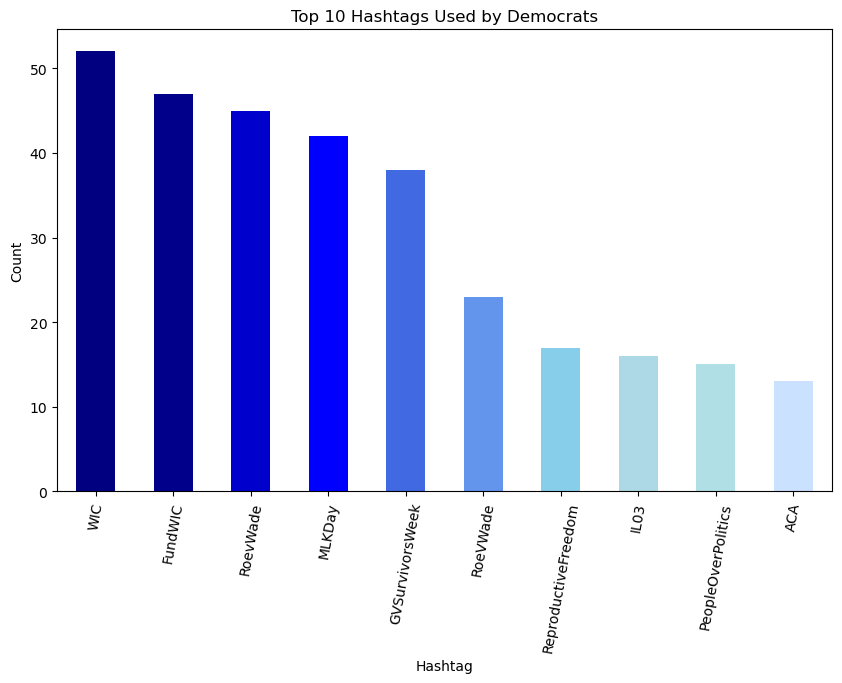

In [34]:
# Plot the 10 most used hasthags for Democrats

# Convert the list of Democrat hashtags to a Pandas Series and count occurrences
democrat_10 = pd.Series(democrat_hashtags).value_counts().head(10)
# Define custome colors to plot
custom_blue_colors = [
    '#000080',  # Navy
    '#00008B',  # Dark blue
    '#0000CD',  # Medium blue
    '#0000FF',  # Blue
    '#4169E1',  # Royal blue
    '#6495ED',  # Cornflower blue
    '#87CEEB',  # Sky blue
    '#ADD8E6',  # Light blue
    '#B0E0E6',  # Powder blue
    '#CAE1FF'   # Light steel blue
]
# Plot
democrat_10.plot(kind='bar', figsize=(10,6), color=custom_blue_colors)
plt.title('Top 10 Hashtags Used by Democrats')
plt.xlabel('Hashtag')
plt.ylabel('Count')
plt.xticks(rotation = 80)

### Word Cloud for Democrat and Republican Hashtags

A word cloud is displayed showing the top hashtags from both republican and democrat hashtags. 

In [35]:
# Word Cloud
!pip install wordcloud
from wordcloud import WordCloud


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


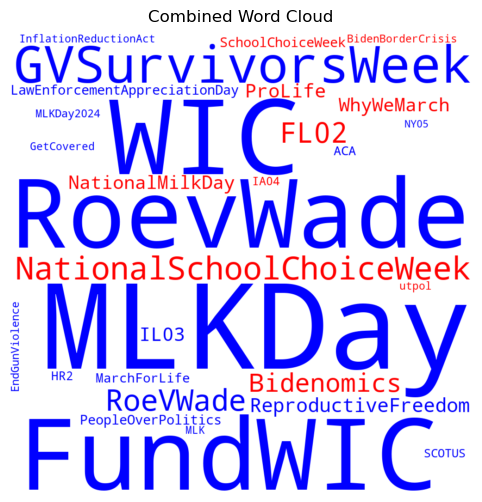

In [36]:
# Example data
democrat_text = " ".join(democrat_hashtags)
republican_text = " ".join(republican_hashtags)

# Function to get word frequencies
def get_word_frequencies(text):
    words = text.split()
    word_freq = {word: words.count(word) for word in set(words)}
    return word_freq

# Get word frequencies for Democrat and Republican hashtags
democrat_word_freq = get_word_frequencies(democrat_text)
republican_word_freq = get_word_frequencies(republican_text)

# Combine word frequencies
combined_word_freq = {word: democrat_word_freq.get(word, 0) + republican_word_freq.get(word, 0) for word in set(list(democrat_word_freq.keys()) + list(republican_word_freq.keys()))}

# Generate word cloud with custom coloring function
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "blue" if word in democrat_word_freq else "red"

wordcloud = WordCloud(width=1000, height=1000,
                      background_color='white',
                      max_words=30,
                      color_func=color_func
                      ).generate_from_frequencies(combined_word_freq)

# Plot the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Combined Word Cloud')
plt.axis('off')
plt.show()


Upon examination, it becomes evident that the majority of frequent hashtags originate from Democrat tweets. This observation might suggest a tendency for Democrats to employ more embellishment when conveying a topic, contrasting with Republicans who appear to express themselves more independently. Additionally, certain hashtags, such as MLKDay, are prevalent in tweets from both parties but are categorized as blue since they appear more frequently in Democrat tweets than in Republican tweets.

In [37]:
# Before preprocessing, we want to make sure the distribution of Democratic and Republican is balanced again

# Count the occurrences of each party in the 'Party' column
parties_counts = df_cleaned['party'].value_counts()

# Calculate the total number of occurrences
normalized_counts = parties_counts.sum()

# Dictionary to store the percentage of tweets for each party
tweets_percentage = {}

# Calculate the percentage of tweets for each party and store in the dictionary
for party, count in parties_counts.items():
    tweets_percentage[party] = f"{count/normalized_counts*100:.2f}%"

# Display the dictionary containing the percentage of tweets for each party
tweets_percentage


{'D': '50.21%', 'R': '49.79%'}

The distribution is fair enough, it is almost 50/50, se we can continue processing the data

## 2. Data Cleaning


In [38]:
# Import necessary Libraries and Modules
import string

# SK Packages
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

## Vectorizers
from sklearn.feature_extraction.text import CountVectorizer

### Defining Stopwords

In [39]:
# NLTK
import nltk

# Downloads
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('words')
nltk.download('stopwords')

# Other nltk modules
from nltk.corpus import stopwords
import nltk as nlp
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import words

import pickle

# Define  customized stopwords
stopwords = stopwords.words('english')
stopwords.extend(["rt", "u", "r", "amp", "w", "th"])  # Add additional stopwords

# remove some stopwords
stopwords.remove('not')
stopwords.remove('against')
stopwords.remove("don't")
stopwords.remove("have")
stopwords.remove("won't")

# Save the stopwords list to a pickle file
with open("custom_stopwords.pkl", "wb") as f:
    pickle.dump(stopwords, f)


# Print the length of the stopwords
len(stopwords)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\erick\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\erick\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\erick\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\erick\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


180

### Tokenization

Performed to clean tweets for smoother modelling, classification and sentiment analysis.

In [40]:
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'c

In [41]:
# save vectorizer
import joblib

# Create a function to clean the tweets
def clean_tweets(tweet):
    # Create a lemmatizer
    lemmatizer = WordNetLemmatizer()

    # Replace "n't" with "not"
    tweet = tweet.replace("n't", " not")

    # Remove @ sign and all handles
    tweet = re.sub("@[A-Za-z0-9]+", "", tweet)

    # Remove hashtags and words that come together with hashtags
    tweet = re.sub(r'#\w+', '', tweet)

    # Remove all punctuation. It also removes hashtags.
    tweet = re.sub("[!@$%^&*()_+\|/?,.:;'`’-]+", " ", tweet)

    # Remove links
    tweet = re.sub(r'http\S+', '', tweet)

    # Lowercase all characters
    tweet = tweet.lower()

    # Remove extra whitespace
    tweet = " ".join(tweet.split())

    # Remove stopwords
    tweet = ' '.join([word for word in tweet.split() if word.lower() not in stopwords])

    # Lemmatization
    tokens = nltk.word_tokenize(tweet)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    tweet = " ".join(lemmatized_tokens)

    # Remove three dots from the final word, preserving the word itself
    tweet = re.sub(r'(\S+)\.{2,}$', r'\1', tweet)
    
    return tweet

# Save the function to a file
joblib.dump(clean_tweets, 'clean_tweets_function.pkl')

# Create a new column with the cleaned text for every tweet
df_cleaned['clean_tweet'] = df_cleaned['tweet'].map(clean_tweets)

In [42]:
# Proof check results
print(df_cleaned['clean_tweet'][1702])
print('')
print(df_cleaned['tweet'][1702])

doj reversal could clear way carroll 1st lawsuit against trump proceed abc news co destipkfij trump proceed 101155027 via wrote questioned bill barr merrick garland judiciary hearing wrong right

DOJ reversal could clear way for Carroll's 1st lawsuit against Trump to proceed - ABC News - https://t.co/dEsTIPKFIJ trump-proceed-101155027 via @ABC
I wrote and questioned both  Bill Barr and Merrick Garland at judiciary hearings about this .Wrong then, right now. @ejeancarroll


In [43]:
# Visualize new columns
df_cleaned.head(10)

,user_id,tweet,party,is_retweet,is_democrat,hashtags,clean_tweet
0,76452765,"On Joe Biden's first day in the Oval Office, h...",R,0,0,None,joe biden first day oval office signed legisla...
1,76452765,I was sorry to hear of the passing of longtime...,R,0,0,None,sorry hear passing longtime caregiver leo lion...
2,76452765,RT @1819News: U.S. Rep. Robert Aderholt (R-Hal...,R,1,0,None,rep robert aderholt haleyville recently took h...
3,76452765,I’m sorry to hear of Anthony’s passing. He fre...,R,0,0,None,sorry hear anthony passing frequently interact...
4,76452765,H.R. 6914 Pregnant Students’ Rights Act: Colle...,R,0,0,None,h 6914 pregnant student right act college univ...
5,76452765,https://t.co/GlzxP4JHKh,R,0,0,None,co glzxp4jhkh
6,76452765,Aderholt takes stand for gun owners against 'l...,R,0,0,None,aderholt take stand gun owner against leftwing...
7,76452765,I am unashamedly Pro-Life. That's why I am pro...,R,0,0,[WhyWeMarch],unashamedly pro life proud have earned scoreca...
8,76452765,I was proud to join this amicus brief led by @...,R,0,0,None,proud join amicus brief led gun owner group no...
9,76452765,"@tgregis68 Yes, several to help the states. Be...",R,0,0,None,yes several help state keep mind united state ...


In order to prevent the 'clean_tweet' column from containing empty strings after the removal of links, a solution will be applied. The 'clean_tweet' column will be populated with the values of any hashtags if they exist. In cases where no hashtags are present, the corresponding rows will be deleted from the dataset.

In [44]:
# Locate rows where 'clean_tweet' is an empty string and 'hashtags' is None
link_tweets_nullhashtags = df_cleaned[(df_cleaned['clean_tweet']=='') & (df_cleaned['hashtags'].isnull())]
length1 = len(link_tweets_nullhashtags)
length2 = len(df_cleaned)


# Drop the rows based on the index
df_cleaned = df_cleaned.drop(link_tweets_nullhashtags.index)


# Reset the index to maintain a continuous index
# Otherwise we will have a dataset with missing indexes (The ones eliminated)
df_cleaned = df_cleaned.reset_index(drop=True)

# Print the updated DataFrame
print(f'The new dataset should be {length2} - {length1} long which is {len(df_cleaned)}')

The new dataset should be 9528 - 5 long which is 9523


In [45]:
# Locate rows where 'clean_tweet' is empty string
link_tweets = df_cleaned[df_cleaned['clean_tweet']=='']
len(link_tweets)

0

In [46]:
# Check results
# There should be an index 5 with what used to be index 6
df_cleaned.head(8)

,user_id,tweet,party,is_retweet,is_democrat,hashtags,clean_tweet
0,76452765,"On Joe Biden's first day in the Oval Office, h...",R,0,0,None,joe biden first day oval office signed legisla...
1,76452765,I was sorry to hear of the passing of longtime...,R,0,0,None,sorry hear passing longtime caregiver leo lion...
2,76452765,RT @1819News: U.S. Rep. Robert Aderholt (R-Hal...,R,1,0,None,rep robert aderholt haleyville recently took h...
3,76452765,I’m sorry to hear of Anthony’s passing. He fre...,R,0,0,None,sorry hear anthony passing frequently interact...
4,76452765,H.R. 6914 Pregnant Students’ Rights Act: Colle...,R,0,0,None,h 6914 pregnant student right act college univ...
5,76452765,https://t.co/GlzxP4JHKh,R,0,0,None,co glzxp4jhkh
6,76452765,Aderholt takes stand for gun owners against 'l...,R,0,0,None,aderholt take stand gun owner against leftwing...
7,76452765,I am unashamedly Pro-Life. That's why I am pro...,R,0,0,[WhyWeMarch],unashamedly pro life proud have earned scoreca...


For these remaining rows which had links as tweets but also have hashtags, we will give the clean tweet column the value of the hashtags.

In [47]:
# Iterate through the indices of tweets containing links
for i in link_tweets.index:
    # Replace the 'clean_tweet' content with the concatenated hashtags
    df_cleaned.at[i,'clean_tweet'] = ' '.join(df_cleaned.at[i, 'hashtags'])
    print(df_cleaned.loc[i])

We can see that hashtags were saved as the content in the clean_tweet column, however we still want to separate the hashtag into words to make sense of them.

Since there are only 9 hashtags, we will do this manually.

In [48]:
# create a list of all the indexes to edit
index_list = [1016, 2304, 2309, 4608, 4616, 4623, 7268, 7531, 9282]

clean_hashtags = ['tune in', 'fidelis ad mortem', 'thank you', 'tuesdays with tom', 'tuesdays with tom', 'tuesdays with tom', 'roe vs wade', 'come and cut it', 'stand with israel']

# Iterate over the index_list and clean_hashtags simultaneously
for i, index in enumerate(index_list):
    df_cleaned.at[index, 'clean_tweet'] = clean_hashtags[i]
    print(df_cleaned['clean_tweet'].loc[index])


tune in
fidelis ad mortem
thank you
tuesdays with tom
tuesdays with tom
tuesdays with tom
roe vs wade
come and cut it
stand with israel


In [69]:
df_cleaned['clean_tweet'].iloc[148]

'unprovoked terrorist attack against israel outrage stand israeli people government dark day must continue support israel right defend'

We have addressed all null 'clean_tweet' values. We can now save this dataframe and proceed with out modeling

### Save new DataFrame

In [49]:
# The Dataframe has been saved into a new CSV in case the following steps are rather performed in a separate notebook.
df_cleaned.to_csv("CleanedRepublicanVsDemocrat.csv", index=False)

# Project Conclusion

In this exploration of political discourse on social media, the objective was to uncover insights into the dynamics of political discussions. Here's a summary of our key findings:

### **Data Overview**

I independently curated the dataset by personally leveraging the Twitter API V2 for scraping. This hands-on approach ensured meticulous control over the data collection process, allowing for a customized and targeted dataset tailored to the specific requirements of our analysis.

The value of this approach lies in the firsthand understanding and insights gained during the data collection. By personally overseeing the scraping process, I acquired in-depth knowledge about potential biases, nuances, and intricacies within the dataset. This level of involvement enhances the credibility and reliability of our findings, as the data is not only relevant to our research questions but also reflects a conscious and informed collection process.

The dataset comprised political tweets covering diverse topics and sentiments. Through Exploratory Data Analysis (EDA) and Feature Engineering, we introduced a "retweets" column and categorized hashtags into Democrat and Republican lists, providing valuable information for analysis.

### **Interpreting Results and Model Use**

My analysis revealed interesting patterns in hashtag usage, hinting at potential communication styles.I trained models to predict party affiliation, emphasizing the importance of a diverse training set for optimal performance.

### **Vectorizer: Analysis of Top Terms and Hashtags by Party**

I delved into top words and hashtags predicting party affiliations, shedding light on distinctive themes within Democrat and Republican tweets.


### Further Steps

1. Streamlit
2. Time-based Analysis: Analyze sentiment trends over time: Collect timestamp of tweets.
3. Topic Modelling